# 📘 IbPRIA 2025 - Data-Efficient Strategies for Object Detection

> 📌 **Note**: You can run this notebook on:
>
> - 💻 Your local machine (Python ≥ 3.8, see `requirements.txt`)
> - 🌐 [Google Colab](https://colab.research.google.com/github/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/blob/main/hands_on_notebook.ipynb)



## ⚙️ Preparation to Run This Notebook

To ensure faster training and better performance, it is recommended to use a **GPU** when running this notebook.

If you're using **Google Colab**, make sure the runtime is configured to use a **GPU** or **TPU**.

> 📌 You can change the runtime by going to:  
> `Runtime` → `Change runtime type` → Select **GPU** or **TPU**

⬇️ See the image below for guidance.

---

**Note:** You can also run this notebook **locally** using your own machine with **CPU only**.  
Training may be slower, but all code will still work correctly.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/colab_1.png)

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/colab_2_3.png)

In [22]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    print("✅ Running on Google Colab")
    # Clone the repository if running in Google Colab
    !git clone https://github.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection.git
    # Change working directory
    os.chdir("IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection")

%pip install -r requirements.txt # Install required packages

10325.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


## ✏️ Annotation Guidelines for Object Detection



In object detection tasks, each image must be labeled with **bounding boxes** that enclose every object the model is expected to detect. For each bounding box, a corresponding **class label** must be assigned.

There are several tools available for this annotation process:

- If you're working with a **small dataset** and need a lightweight solution, we recommend [labelImg](https://pypi.org/project/labelImg/).
- For **larger projects** with multiple annotators, we suggest using a more robust platform such as [Label Studio](https://labelstud.io/), which provide better support for collaboration.

### Bounding Box Best Practices

A bounding box is defined by its **center coordinates**, **width**, and **height**. For accurate annotations:

- The **center of the bounding box** should align with the center of the corresponding object.
- The edges of the bounding box should **not exceed the boundaries** of the object.
- Boxes should be **tight** but not overly precise — enough to capture the object clearly without including background noise.

> Ensuring consistent and accurate annotation is crucial, as it directly impacts the performance and reliability of the trained object detection model.

### Running LabelImg Locally

If you're running this notebook or working locally (not on Colab), you can install and launch **LabelImg** using the commands below:

```bash
pip install labelImg
```
**Important:** LabelImg works best with Python 3.9 or lower. Newer versions may cause compatibility issues. We recommend using a virtual environment with Python 3.9 if needed.

To lauch the tool:
```bash
labelImg
```

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/labelimg.png)

## 📂 Dataset Format for YOLO Training


To train a YOLO model, your dataset must follow a specific structure and include a `.yaml` configuration file that defines where your images and annotations are located, along with the list of classes.

---

### Folder Structure

Each image should have a corresponding `.txt` annotation file with the same name (e.g., `image1.jpg` ↔ `image1.txt`), and these should be placed in the appropriate subfolders.

```text
dataset/
├── train/
├── val/
├── test/
└── data.yaml
```

> **Note:** YOLO expects labels in `.txt` format where each line corresponds to one bounding box, with the format:
>
> ```
> <class_id> <x_center> <y_center> <width> <height>
> ```
> All values must be normalized (from 0 to 1) relative to image size.

---

### `data.yaml` Example

```yaml
train: dataset/train/images
val: dataset/val/images
test: dataset/test/images

nc: 1  # number of classes
names: ['WF'] #name of the class that MUST match the <class_id> in the annotation file
```

## 👁️ Object Detection with YOLOv11


Once your dataset is prepared and organized correctly, you can begin training your YOLOv11 model. In this example, we’ll use the **nano version** of YOLOv11 (`yolov11n.pt`) and train on a custom dataset.


### Step 1: Dataset Splitting

We use a utility function to split the dataset into **training** and **validation** sets, assuming a separate **test set** already exists.

This example splits a dataset of 200 images into:
- **60% for training**
- **20% for validation**
- The remaining **20% are reserved as the test set**

In [23]:
from utils import get_split, split_dataset

# Get train/val split from dataset (test already fixed)
train, val = get_split(train_size=0.6, val_size=0.2, dataset_size=200)

# Save to dataset/run/train and dataset/run/val
split_dataset(train_split=train, val_split=val)
print("Train and validation splits saved successfully.")

Train and validation splits saved successfully.


### Step 2: Model Training

After the dataset splitting process, it is important to define the training parameters.

Some important parameters to define are: **image size**, number of **epochs**, how to initialize the model **weights**, and the **batch size**.

Let us clarify each of them:

**Image size** refers to the resolution to which every input image is resized before being fed into the yolov11 model. This fixed-size input is necessary because the model architecture (fully convolutional with final dense layers) expects inputs of the same size.

An **epoch** is one complete pass through the entire training dataset by the learning algorithm.

Pre-trained **weights** are obtained by training a model on a large dataset before applying it to a specific task. This approach leverages **transfer learning**, allowing the model to take advantage of already learned general features such as edges, textures, or shapes. We will further explore **transfer learning** and its advantages.

Finally, **batch size** is the number of training samples processed before the model updates its weights.

For each batch:
- The model makes predictions.
- The loss is computed.
- The optimizer adjusts weights using gradients from that batch.

In [24]:
from utils import train_yolo

project = "example_simple_detector" # Project directory for saving results

name = "yolov11n_custom"

image_size = 1280 # Image size for training
epochs = 10 # Number of epochs for training
batch_size = 4 # Batch size for training

# Train the YOLO model
trained = train_yolo(
    img=image_size, # Image size
    epochs=epochs, # Number of epochs
    data="dataset/data.yaml", # Path to data configuration file
    weights="yolo11n.pt", # Pre-trained weights from COCO dataset
    batch=batch_size, # Batch size
    name=name, # Name of the training run
    project=project # Project directory for saving results
)

Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 1298.63it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7902.8±1068.0 MB/s, size: 748.8 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 2066.01it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache


Plotting labels to example_simple_detector/yolov11n_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to example_simple_detector/yolov11n_custom
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.166      3.361      1.042        221       1280: 100%|██████████| 30/30 [01:53<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]

                   all         40       1932     0.0113     0.0704    0.00987    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.779      1.992     0.9148        100       1280: 100%|██████████| 30/30 [01:49<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

                   all         40       1932     0.0588      0.365      0.231     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       1.83       1.89     0.9192        101       1280: 100%|██████████| 30/30 [01:47<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:18,  4.51s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:14,  4.84s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 3/5 [00:14<00:10,  5.03s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:19<00:04,  4.86s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.83s/it]

                   all         40       1932      0.506      0.537      0.472      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.858       1.78     0.9515        138       1280: 100%|██████████| 30/30 [01:44<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:18,  4.52s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:14,  4.88s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 3/5 [00:14<00:10,  5.06s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:19<00:04,  4.90s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]

                   all         40       1932      0.639       0.46      0.503       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.774      1.711     0.9285        232       1280: 100%|██████████| 30/30 [01:50<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:18,  4.62s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:13,  4.63s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:18<00:04,  4.50s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.60s/it]

                   all         40       1932      0.694      0.633       0.69      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.637      1.608     0.9065        123       1280: 100%|██████████| 30/30 [01:52<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:04<00:17,  4.36s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:09<00:13,  4.64s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         40       1932      0.717      0.672      0.734      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.572      1.482     0.8979        228       1280: 100%|██████████| 30/30 [01:43<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.93s/it]

                   all         40       1932      0.742      0.709      0.782       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.534      1.416     0.8966        116       1280: 100%|██████████| 30/30 [01:42<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]

                   all         40       1932      0.768       0.73      0.805      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.523      1.401     0.8807        214       1280: 100%|██████████| 30/30 [01:42<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

                   all         40       1932      0.779      0.744      0.822      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.448      1.291     0.8887        618       1280: 100%|██████████| 30/30 [01:47<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

                   all         40       1932      0.798      0.738      0.826      0.504



10 epochs completed in 0.353 hours.
Optimizer stripped from example_simple_detector/yolov11n_custom/weights/last.pt, 5.6MB
Optimizer stripped from example_simple_detector/yolov11n_custom/weights/best.pt, 5.6MB

Validating example_simple_detector/yolov11n_custom/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


                   all         40       1932      0.797      0.739      0.826      0.504
Speed: 3.8ms preprocess, 166.4ms inference, 0.0ms loss, 153.7ms postprocess per image
Results saved to example_simple_detector/yolov11n_custom


### Step 3: Detection with the Trained Model

Once your model has been trained, you can use it to detect objects in new images.

Below is an example of how to **load your trained YOLOv11 model**, run inference on a single image, and **visualize the results** using `OpenCV` and `matplotlib`.

In [25]:
from utils import detect_yolo
import os
from IPython.display import Image, Video, display

file_to_detect = 'examples/example_video.mp4'  # or use an image like 'dataset/improved/2.jpg'
# file_to_detect = 'dataset/improved/2.jpg'

# Run detection using the trained YOLO model
results = detect_yolo(
    source=file_to_detect,
    weights=f"{project}/{name}/weights/best.pt",
    img=image_size,
)

# Get the output path
output_dir = results[0].save_dir  # YOLO typically saves to 'runs/detect/<name>/'
file_name = os.path.basename(file_to_detect)
output_path = os.path.join(output_dir, file_name)

# Display output based on extension
if file_to_detect.lower().endswith(('.jpg', '.jpeg', '.png')):
    display(Image(filename=output_path))
elif file_to_detect.lower().endswith(('.mp4', '.mov', '.avi')):
    display(Video(filename=output_path))
else:
    print(f"Unsupported file type: {file_to_detect}")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/388) /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/examples/example_video.mp4: 736x1280 16 Whiteflys, 118.8ms
video 1/1 (frame 2/388) /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/examples/example_video.mp4: 736x1280 15 Whiteflys, 120.0ms
video 1/1 (frame 3/388) /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/examples/example_

## 🤖 Active Learning

The goal of **Active Learning (AL)** is to select the **most relevant samples** to be labeled first and used to train a model.  
This approach is particularly useful when **labeling data is expensive or time-consuming**.

Even with a **small initial set of labeled data**, it is possible to train a baseline model.  
To improve the model further, we need more labeled data — but instead of labeling everything, **Active Learning helps prioritize** which samples to label.

### Active Learning Strategies

There are two main approaches to Active Learning:

#### Stream-Based Selective Sampling

- Unlabeled data points are processed **one at a time**.
- For each sample, the model must decide **immediately** whether to query its label or discard it.
- Useful when data arrives in real time or memory is limited.

#### Pool-Based Sampling

- The model evaluates a **pool of unlabeled data** all at once.
- Each sample is scored based on a **relevance criterion** (e.g., confidence, entropy).
- The **top-K most informative** samples are selected and labeled.
- This is the most commonly used method in practice.

In Pool-based the process works as follows:

##### 1. A model is trained on the current labeled dataset.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_1.png)

##### 2. The model is then used to evaluate the **unlabeled data**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_2.png)

##### 3. Based on its predictions, the model **scores all unlabeled samples** using a selection strategy (e.g., uncertainty, disagreement, diversity).
   - Samples are then **ranked** by relevance.
   - Common scoring strategies include:
     - **Uncertainty sampling**: Select samples with the lowest confidence (highest uncertainty).
     - **Diversity sampling**: Choose a diverse set of samples to maximize information gain and avoid redundancy.
     - **Representativeness**: Pick samples that best represent the distribution of the overall data.
     - **Entropy-based sampling**: Select samples with the highest prediction entropy (more confusion between classes).

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_3.png)

##### 4. Based on the ranking, the **top-K most relevant samples are selected, labeled by an expert, and added to the labeled set**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_4.png)

##### 5. This cycle repeats, improving the model efficiently while **minimizing annotation effort**.

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/al_5.png)

---

By focusing labeling efforts on the **most informative samples**, Active Learning enables more efficient training and faster model improvement.

### Experiment Preparation

In this section, we evaluate the impact of **Active Learning (AL)** in a Pool-based scenario by training and comparing **two models**:

##### Incremental Training Strategy

Both models are trained **incrementally**:

- Training begins with a **small subset** of images for training and validation.
- At each iteration, a **new batch of data** is added to the training and validation sets.
- A new model is trained after each update.
- This process is repeated for a fixed number of iterations, defined by the variable `num_batches`.

The number of images added in each iteration is determined by:

- `batch_train_proportion * dataset_size` for training images
- `batch_val_proportion * dataset_size` for validation images

---

##### Model Variants

- **Active Learning Model:**  
  Selects new images based on **model uncertainty**, e.g., low confidence in predictions. This ensures the **most informative** samples are used in training in first place.

- **Random Selection Model:**  
  Selects new images **randomly** from the unlabeled pool at each iteration, serving as a baseline for comparison.

---

##### ⚙️ Key Parameters

- `num_batches`: Number of incremental iterations (rounds of training)
- `batch_train_proportion`: Proportion of the dataset used for training in each batch
- `batch_val_proportion`: Proportion of the dataset used for validation in each batch

These parameters control **how much data is added per iteration** and ensure both models grow in training size at the same pace, allowing for a fair comparison.

---

📈 At the end of the experiment, we compare the models using their **mAP@50** scores across iterations to evaluate which strategy learns more efficiently.

In [26]:
from utils import get_split, split_dataset, new_batch, train_yolo, test_yolo
import pandas as pd
from IPython.display import clear_output

# -------- Dataset setup --------
# Define dataset parameters

dataset_size = 200 # Total number of images in the dataset
num_batches = 8 # Number of batches to process
batch_train_prop = 0.6 / num_batches # Proportion of images in each batch for training (60% of the dataset)
batch_val_prop = 0.2 / num_batches # Proportion of images in each batch for validation (20% of the dataset)

num_epochs = 20 # Number of epochs for each training run
batch_size = 4 # Batch size for training
image_size = 1280 # Image size for detection

# Project base
project = "example_active_learning" # Base project directory for saving results
base_weights = "yolo11n.pt" # Pre-trained weights to start training from

results_df = pd.DataFrame(index=range(num_batches)) # DataFrame to store results

# -------- Initial split --------
# Get initial train/val split for the first batch 
# this will ensure both models start with the same initial data
initial_train_split, initial_val_split = get_split(
                train_size=batch_train_prop,
                val_size=batch_val_prop,
                dataset_size=dataset_size
            ) 

### Model Training

In [27]:
# Define a function to run a full mode (AL or random)
def run_training_loop(mode="al"):

    for batch in range(num_batches): # Loop through each batch
        print(f"\n=== Batch {batch} / {num_batches} — Mode: {mode} ===")
        name = f"{mode}_batch_{batch}" # Name for the current batch run (directory)

        if batch == 0: # First batch, use initial split
            split_dataset(train_split=initial_train_split, val_split=initial_val_split)
        else: # Subsequent batches, select new data
            new_batch(
                random=(mode == "random"), # Random selection if mode is "random"
                al="confidence", # Use confidence-based selection for active learning (other opriont: "count" - selected images with the most detections)
                weights=weights, # Weights from the previous batch
                train_images=int(batch_train_prop * dataset_size),
                val_images=int(batch_val_prop * dataset_size),
                project=f"{project}_{mode}/detecting",
                name=name,
                dataset="original",
                img_size=image_size
            )
        
        # Train the YOLO model with the selected data
        results = train_yolo(
            img=image_size,
            epochs=num_epochs,
            data="dataset/data.yaml",
            weights=base_weights, # Use base weights for training (always start from scratch)
            batch=batch_size,
            name=name,
            project=f"{project}_{mode}/training"
        )

        weights = f"{project}_{mode}/training/{name}/weights/best.pt" # Weights used to compute most relevant images in the next batch and for testing
        test_results = test_yolo(
            img=image_size,
            data="dataset/data.yaml",
            weights=weights, # Weights from the model trained in this batch
            project=f"{project}_{mode}/testing"
        )
        mAP_test = float(test_results.results_dict["metrics/mAP50(B)"])
        mAP = float(results.results_dict["metrics/mAP50(B)"])
        #results_df.loc[batch, f"{mode}_mAP"] = mAP
        results_df.loc[batch, f"{mode} mAP (test)"] = mAP_test
        print(f"✅ Batch {batch + 1} ({mode}) done — mAP@50: {mAP:.4f}")

# Run both modes
run_training_loop(mode="al")
run_training_loop(mode="random")

clear_output(wait=True)

# View combined results
display(results_df)
%matplotlib inline
results_df.plot(
    y=["al mAP (test)", "random mAP (test)"],
    marker='o',
    title="Active Learning vs Random Selection (mAP@50)"
)
import matplotlib.pyplot as plt
plt.xlabel("# images")
plt.ylabel("mAP (test set)")
plt.xticks(ticks=results_df.index, labels=[int((i+1)*(batch_train_prop+batch_val_prop)*dataset_size) for i in results_df.index])
plt.show()


=== Batch 0 / 8 — Mode: al ===
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=al_batch_0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 2604.73it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9755.0±1676.2 MB/s, size: 767.5 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 3515.76it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_0/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.832      4.286      1.212        124       1280: 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all          5        390          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.511      3.976      1.094        158       1280: 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all          5        390          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.185      3.658      1.027        196       1280: 100%|██████████| 4/4 [00:13<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all          5        390          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.898      3.398      1.012         93       1280: 100%|██████████| 4/4 [00:16<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          5        390    0.00667     0.0256    0.00956    0.00254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.813      3.016     0.9313        166       1280: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          5        390     0.0153      0.059     0.0415     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.972      2.999     0.9465         85       1280: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all          5        390      0.024     0.0923     0.0749     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.918      2.593     0.9274        250       1280: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          5        390      0.024     0.0923     0.0749     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.826      2.351     0.9382        155       1280: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          5        390     0.0273      0.105     0.0751     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.789      2.269     0.9222        212       1280: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          5        390      0.034      0.131     0.0904      0.023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.769       2.05     0.9029        239       1280: 100%|██████████| 4/4 [00:13<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          5        390      0.034      0.131     0.0904      0.023


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.664      1.973     0.9269         63       1280: 100%|██████████| 4/4 [00:13<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all          5        390       0.04      0.154      0.095     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.741      1.943     0.9159        186       1280: 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          5        390       0.04      0.154      0.095     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.682      2.066     0.9276         95       1280: 100%|██████████| 4/4 [00:13<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          5        390      0.054      0.208      0.116     0.0377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.716      1.878     0.9127        143       1280: 100%|██████████| 4/4 [00:13<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          5        390      0.054      0.208      0.116     0.0377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.615      1.746     0.9176         77       1280: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          5        390      0.092      0.354      0.277      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.578      1.718     0.9113        139       1280: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          5        390      0.092      0.354      0.277      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.815      2.021     0.9411        142       1280: 100%|██████████| 4/4 [00:14<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all          5        390      0.092      0.354      0.277      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.669       1.78     0.9097        255       1280: 100%|██████████| 4/4 [00:13<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all          5        390      0.127       0.49      0.418      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.678      1.984     0.9277         80       1280: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          5        390      0.127       0.49      0.418      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.523      1.695     0.8979        181       1280: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          5        390      0.127       0.49      0.418      0.222



20 epochs completed in 0.091 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_0/weights/last.pt, 5.6MB
Optimizer stripped from example_active_learning_al/training/al_batch_0/weights/best.pt, 5.6MB

Validating example_active_learning_al/training/al_batch_0/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


                   all          5        390      0.127       0.49      0.418      0.222
Speed: 2.9ms preprocess, 185.1ms inference, 0.0ms loss, 82.4ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_0
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1259.2±160.7 MB/s, size: 770.2 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.29s/it]


                   all         40       2060     0.0824       0.48      0.373      0.195
Speed: 2.1ms preprocess, 436.6ms inference, 0.0ms loss, 77.9ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 1 (al) done — mAP@50: 0.4182

=== Batch 1 / 8 — Mode: al ===
Creating new batch with 15 train images and 5 validation images.
Using active learning mode: confidence
Available indices for new batch: 140
Detection directory created at: dataset/detect

image 1/140 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 1280x1280 (no detections), 167.9ms
image 2/140 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 1280x1280 (no detections), 169.3ms
image 3/140 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/10.jpg: 1280x1280 (no detections), 164.4ms
image 4/140 /Users/ddcosta/Desktop/IbPRIA2015---Data-E

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 30 images, 2 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 1870.09it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3696.3±4308.0 MB/s, size: 849.5 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1828.86it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_1/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.777      4.058      1.167        158       1280: 100%|██████████| 8/8 [00:28<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         10        585   0.000333    0.00171   0.000187   7.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.238      3.611      1.061         92       1280: 100%|██████████| 8/8 [00:25<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

                   all         10        585      0.008      0.041    0.00901    0.00218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G       2.13      3.085     0.9866        100       1280: 100%|██████████| 8/8 [00:24<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]

                   all         10        585     0.0113     0.0581    0.00872    0.00208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.242      2.751     0.9881         51       1280: 100%|██████████| 8/8 [00:24<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

                   all         10        585     0.0107     0.0547    0.00863     0.0023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.027      2.111     0.9555        103       1280: 100%|██████████| 8/8 [00:24<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

                   all         10        585    0.00967     0.0496     0.0107    0.00352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.058      2.059      0.968        166       1280: 100%|██████████| 8/8 [00:28<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

                   all         10        585    0.00833     0.0427    0.00529    0.00209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.007      1.914     0.9544         90       1280: 100%|██████████| 8/8 [00:29<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                   all         10        585      0.055      0.282      0.186     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.089      2.242     0.9444         26       1280: 100%|██████████| 8/8 [00:27<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all         10        585     0.0847      0.434      0.282     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.988      2.128     0.9696         36       1280: 100%|██████████| 8/8 [00:24<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

                   all         10        585      0.124      0.636      0.388      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.965      1.826     0.9767         98       1280: 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

                   all         10        585      0.124      0.636      0.388      0.154


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      2.029       2.21     0.9896         57       1280: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         10        585      0.203      0.771      0.494      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      2.146      2.212     0.9774        103       1280: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         10        585      0.203      0.771      0.494      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.812       1.89      0.997         61       1280: 100%|██████████| 8/8 [00:24<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all         10        585      0.656      0.472      0.545      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.854      1.829     0.9894        106       1280: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

                   all         10        585      0.656      0.472      0.545      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.957       2.12     0.9805        100       1280: 100%|██████████| 8/8 [00:25<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]

                   all         10        585       0.67      0.482      0.594      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.803      1.863      0.945         46       1280: 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]

                   all         10        585       0.67      0.482      0.594      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.812      1.896      0.955         43       1280: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]

                   all         10        585       0.64      0.554      0.625      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.797      1.817     0.9727        122       1280: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]

                   all         10        585       0.64      0.554      0.625      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.714      1.745     0.9681         36       1280: 100%|██████████| 8/8 [00:29<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         10        585      0.649      0.591      0.657      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.718      1.732     0.9694         70       1280: 100%|██████████| 8/8 [00:28<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         10        585      0.649      0.591      0.657      0.336



20 epochs completed in 0.171 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_1/weights/last.pt, 5.6MB
Optimizer stripped from example_active_learning_al/training/al_batch_1/weights/best.pt, 5.6MB

Validating example_active_learning_al/training/al_batch_1/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


                   all         10        585      0.647      0.591      0.658      0.336
Speed: 3.9ms preprocess, 194.1ms inference, 0.0ms loss, 178.6ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_1
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1446.9±337.0 MB/s, size: 780.6 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:11<00:23, 11.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.74s/it]


                   all         40       2060      0.653      0.387      0.446      0.248
Speed: 3.0ms preprocess, 449.6ms inference, 0.0ms loss, 168.2ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 2 (al) done — mAP@50: 0.6575

=== Batch 2 / 8 — Mode: al ===
Creating new batch with 15 train images and 5 validation images.
Using active learning mode: confidence
Available indices for new batch: 120
Detection directory created at: dataset/detect

image 1/120 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 1280x1280 10 Whiteflys, 162.3ms
image 2/120 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 1280x1280 10 Whiteflys, 168.4ms
image 3/120 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/10.jpg: 1280x1280 3 Whiteflys, 167.4ms
image 4/120 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 45 images, 2 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 1953.97it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5642.1±5203.9 MB/s, size: 987.1 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 2149.38it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.717      4.026      1.136         89       1280: 100%|██████████| 12/12 [00:46<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]

                   all         15       1107    0.00267     0.0108    0.00311   0.000822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.374      3.423      1.012         28       1280: 100%|██████████| 12/12 [00:38<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

                   all         15       1107    0.00778     0.0316    0.00514    0.00165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.149      7.034     0.9058          0       1280: 100%|██████████| 12/12 [00:43<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]

                   all         15       1107     0.0164     0.0668     0.0217     0.0053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.206      2.382     0.9522         14       1280: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

                   all         15       1107    0.00978     0.0397    0.00902    0.00209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.322      2.378     0.9583         95       1280: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]

                   all         15       1107      0.006     0.0244    0.00348    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.266      2.348     0.9822         44       1280: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]

                   all         15       1107     0.0664       0.27      0.118     0.0471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.328      2.166     0.9601        147       1280: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]

                   all         15       1107     0.0664       0.27      0.118     0.0471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.302      2.019     0.9522         97       1280: 100%|██████████| 12/12 [00:40<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.79s/it]

                   all         15       1107      0.146      0.592      0.392      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      2.284       2.02     0.9777        159       1280: 100%|██████████| 12/12 [00:40<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]

                   all         15       1107      0.644      0.393      0.494      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      2.339      2.103     0.9623        304       1280: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]

                   all         15       1107      0.563      0.499      0.492       0.19


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      2.147          2     0.9774         45       1280: 100%|██████████| 12/12 [00:38<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]

                   all         15       1107      0.563      0.499      0.492       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      2.088      2.003     0.9792         34       1280: 100%|██████████| 12/12 [00:38<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]

                   all         15       1107      0.528      0.535      0.483      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      2.104      2.001     0.9561         73       1280: 100%|██████████| 12/12 [00:40<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.56s/it]

                   all         15       1107      0.526      0.516      0.475      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.992      1.906     0.9492         28       1280: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]

                   all         15       1107       0.57      0.526       0.51      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      2.029       1.97     0.9468        234       1280: 100%|██████████| 12/12 [00:40<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.50s/it]

                   all         15       1107       0.57      0.526       0.51      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      2.116      1.877     0.9573         90       1280: 100%|██████████| 12/12 [00:39<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.50s/it]

                   all         15       1107      0.589      0.541      0.541      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G       2.17       1.98     0.9717         39       1280: 100%|██████████| 12/12 [00:40<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.50s/it]

                   all         15       1107      0.617       0.59      0.604       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.914      1.685     0.9462         14       1280: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.37s/it]

                   all         15       1107      0.602      0.595      0.597      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.927      1.697     0.9273         28       1280: 100%|██████████| 12/12 [00:38<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]

                   all         15       1107      0.602      0.595      0.597      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.923      1.768     0.9447         17       1280: 100%|██████████| 12/12 [00:40<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]

                   all         15       1107      0.605      0.612        0.6       0.28



20 epochs completed in 0.270 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_2/weights/last.pt, 5.6MB
Optimizer stripped from example_active_learning_al/training/al_batch_2/weights/best.pt, 5.6MB

Validating example_active_learning_al/training/al_batch_2/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


                   all         15       1107      0.603      0.595      0.597      0.281
Speed: 7.6ms preprocess, 172.7ms inference, 0.0ms loss, 286.3ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_2
Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 995.4±556.8 MB/s, size: 769.4 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:11<00:23, 11.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:27<00:00,  9.17s/it]


                   all         40       2060      0.674      0.525      0.578       0.33
Speed: 3.5ms preprocess, 448.5ms inference, 0.0ms loss, 181.5ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 3 (al) done — mAP@50: 0.5973

=== Batch 3 / 8 — Mode: al ===
Creating new batch with 15 train images and 5 validation images.
Using active learning mode: confidence
Available indices for new batch: 100
Detection directory created at: dataset/detect

image 1/100 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 1280x1280 46 Whiteflys, 172.9ms
image 2/100 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 1280x1280 52 Whiteflys, 171.1ms
image 3/100 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/101.jpg: 1280x1280 34 Whiteflys, 168.1ms
image 4/100 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficien

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 60 images, 2 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 2192.01it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3139.6±3590.0 MB/s, size: 885.2 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 2650.43it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.653      4.077      1.136        265       1280: 100%|██████████| 15/15 [00:56<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

                   all         20       1483   0.000167   0.000674   8.34e-05    2.5e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.504      3.135      1.046        255       1280: 100%|██████████| 15/15 [01:00<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]

                   all         20       1483     0.0005    0.00202    0.00026   5.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.312      2.521      1.001        282       1280:  20%|██        | 3/15 [00:14<00:56,  4.69s/it]


KeyboardInterrupt: 

## 🧹 Data Quality

In object detection, **annotation quality** plays a critical role in model performance.

Unlike classification tasks, object detection requires:
- The correct **label** for each object
- A precise **bounding box** tightly enclosing the object


### Common Annotation Issues

- **Incorrect Labels**: The object is mislabeled or assigned the wrong class.
- **Poor Bounding Boxes**:
  - Boxes do not align with the object
  - Boxes are too loose or too tight
  - Boxes include multiple objects
- **Inconsistent Annotations** across similar samples

Such errors often stem from:
- **Repetitive labeling** tasks
- **Fatigue** or insufficient training of annotators

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/data_quality.png)

### Annotation Quality Example: Original vs Improved Labels

As an illustration of the importance of annotation quality, this notebook includes **two versions of the same dataset**:

- `dataset/original/`: Contains the original annotations
- `dataset/improved/`: Contains refined, higher-quality annotations

Both versions share the **same images**, but differ in the accuracy and consistency of their bounding boxes and labels.

This allows us to analyze:
- How labeling precision impacts training performance
- Whether better annotations lead to **higher mAP** and more reliable predictions

By training the same model on each version, we can measure how much improvement is achieved **purely through better annotations** — without changing the model architecture or training strategy.

> This is especially useful in real-world projects, where annotation time is expensive, and correcting label errors can be more effective than adding more data.

#### Experimentation Preparation

In this experiment, **two models are trained using the same set of images**, but with **different annotations**.  
This setup is designed to evaluate the impact of **annotation quality** on the performance of an object detection model.

- Both models share the **same training and validation splits**, ensuring a fair and controlled comparison.
- The only difference lies in the annotations:
  - One model uses the **original** annotation set.
  - The other uses a set of **improved** annotations.

---

At the end of training, we compare the models using the **mAP@50 metric** to assess how annotation quality affects detection performance.

In [ ]:
from utils import get_split, split_dataset, train_yolo, test_yolo
from IPython.display import clear_output
from IPython.display import display, Markdown

# Get train/val split from dataset (test already fixed)
train_split, val_split = get_split(
    train_size=0.6,
    val_size=0.2,
    dataset_size=200
)

image_size = 1280 # Image size for training
num_epochs = 20 # Number of epochs for training
batch_size = 4 # Batch size for training

#### Model Training

In [ ]:
def train_and_test_yolo(name):
    # Train and test YOLO model with original annotations
    train_yolo(
        img=image_size,
        epochs=num_epochs,
        data="dataset/data.yaml",
        weights="yolo11n.pt",
        batch=batch_size,
        name=name,
        project="example_data_quality/train"
    )
    
    map_results = test_yolo(
        img=image_size,
        data="dataset/data.yaml",
        weights=f"example_data_quality/train/{name}/weights/best.pt",
        project="example_data_quality/test"
    )
    
    return float(map_results.results_dict["metrics/mAP50(B)"])

#---------- Original Annotations ----------

# Preparing the dataset with the original annotaions
split_dataset(train_split=train_split, val_split=val_split, dataset="original") 
# Train and test the model with original annotations
map_original = train_and_test_yolo("original")

#---------- Improved Annotations ----------

# Preparing the dataset with the improved annotaions
split_dataset(train_split=train_split, val_split=val_split, dataset="improved") # Preparing the dataset with the improved annotaions
# Train and test the model with improved annotations
map_improved = train_and_test_yolo("improved") # Train and test the model with improved annotations

#--------- Calculate improvement ---------

# Calculate the absolute and relative improvement in mAP
improvement = map_improved - map_original
# Calculate the percentage improvement
percent_improvement = (improvement / map_original) * 100 if map_original > 0 else float('inf')  # Avoid division by zero
# Clear training outputs
clear_output(wait=True)
# Display the results in a Markdown format
display(Markdown(f"""
---
### **Annotation Quality Comparison**

- <span style="color:crimson"><b>mAP with original annotations:</b></span> <code>{map_original:.4f}</code>
- <span style="color:seagreen"><b>mAP with improved annotations:</b></span> <code>{map_improved:.4f}</code>

**Absolute improvement:** <b style="color:royalblue">{improvement:.4f} mAP@50</b>  
**Relative improvement:** <b style="color:royalblue">{percent_improvement:.2f}%</b>
"""))


## 🧠 Transfer Learning

Training object detection models from scratch can be time-consuming and data-hungry. To overcome this, we use **Transfer Learning (TL)** — a technique that leverages a model pre-trained on a large dataset (e.g., COCO) and adapts it to our custom task.


#### What Can Change?

- The model’s **detection head** (final layers) is updated to match the number of classes in our current dataset.
- During training, the model retains the **general visual features** it has already learned (e.g., shapes, textures), while adapting to our specific setting.

> Transfer Learning helps us build accurate models faster, even with relatively small datasets — by reusing knowledge from related tasks.


#### Why Use Transfer Learning?

- **Jump-start training** with already-learned features
- **Reduce training time**
- **Improve performance**, especially when labeled data is limited

### Reusing a YOLOv5 Model

#### Approach

In this tutorial, we leverage **Transfer Learning** by starting from a pre-trained **YOLOv5** model trained to detect **whiteflies in yellow sticky traps**:

`pre-trained/yellow_trap.pt`

Although the original model was trained on the **same task** (whitefly detection), it was collected in a **different environment**. This makes it an excellent candidate for fine-tuning on our custom data.

##### YOLOv5 pre-trained on:

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/tl_v5.png)

##### New Dataset

![](https://raw.githubusercontent.com/dinisdcosta/IbPRIA2025---Data-Efficient-Strategies-for-Object-Detection/main/images/tl_new.png)

As seen in the images above, both scenarios contain **whiteflies**, but in different environments.  
A model trained on one of these image sets can be used as a **starting point** for training on the other, leveraging the benefits of **transfer learning**.

> Recent YOLO models (version 8 and above) are available through the **Ultralytics Python library**.  
> However, in this tutorial, we use a **pre-trained YOLOv5 model**, which is **not included** in the `ultralytics` package.

> Therefore, we need to **clone the YOLOv5 repository manually** to access its training and inference utilities.

> **Note:** The YOLOv5 repository is no longer actively maintained and may produce several warnings during training due to updates in related packages.  
> Despite this, it remains **fully functional** and suitable for our fine-tuning task.

#### Cloning YOLOv5 github repository

In [ ]:
!git clone https://github.com/ultralytics/yolov5

#### Experience Preparation

In this transfer learning experiment, we train **two distinct models** for comparison:

- **Model A:** Starts training using the weights of a **pre-trained YOLOv5** model  
- **Model B:** Trains **from scratch** using **YOLOv11n**, with no prior learning

Both models are trained using the **same dataset**, including:

- Identical **training and validation splits**
- Same **number of epochs**, **image size**, and **batch size**

---

At the end of training, a plot is displayed showing the **evolution of performance (mAP@50)** across epochs for both models, allowing us to visualize and compare their learning behavior.

In [ ]:
from utils import get_split, split_dataset, train_yolo, train_yolov5
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt

# Get train/val split from dataset (test already fixed 20%)
train_split, val_split = get_split(
    train_size=0.6, # 60 percent of the dataset for training
    val_size=0.2, # 20 percent of the dataset for validation
    dataset_size=200
)

# Images to be used for training and validation will be available in dataset/run
split_dataset(train_split=train_split, val_split=val_split, dataset="improved")

num_epochs = 5 # Number of epochs for training
batch_size = 4 # Batch size for training

#### Model Training

In [ ]:
# Train YOLOv5 with transfer learning using pre-trained weights
train_yolov5(
    img=1280, # pre-trained/yellow_trap.pt was trained on 1280x1280 images, so we use the same size
    epochs=num_epochs,
    data="dataset/data_yolov5.yaml",
    weights="pre-trained/yellow_trap.pt",  # Using YOLOv5 small as the pre-trained model
    batch=batch_size,
    name="transfer_learning",
    project="example_transfer_learning"
)

# Train YOLOv11 from scratch on the same dataset
train_yolo(
    img=1280,
    epochs=num_epochs,
    data="dataset/data.yaml",
    weights="yolo11n.yaml",
    batch=batch_size,
    name="baseline",
    project="example_transfer_learning/train"
)

clear_output(wait=True)

print("Training completed successfully. Results saved in 'example_transfer_learning/train/transfer_learning' and 'example_transfer_learning/train/baseline'.")

Training completed successfully. Results saved in 'example_transfer_learning/train/transfer_learning' and 'example_transfer_learning/train/baseline'.


#### Plot Comparison

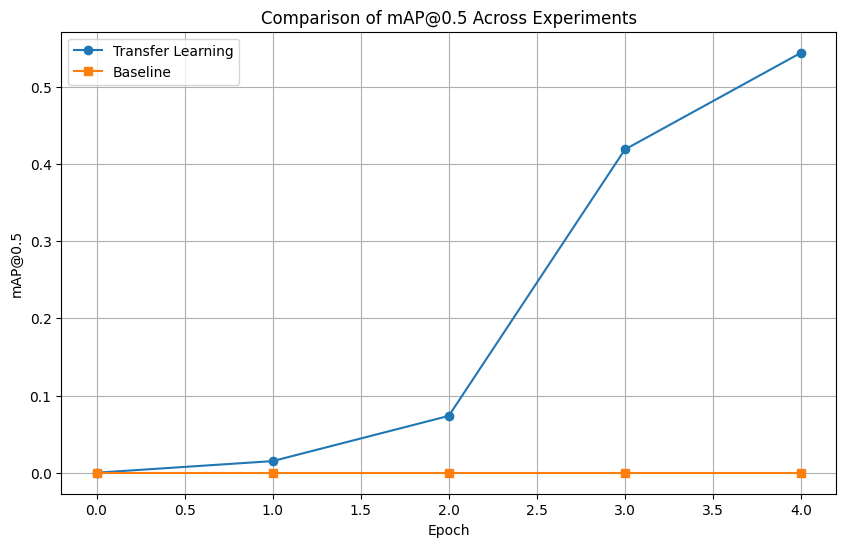

In [ ]:
df1 = pd.read_csv("example_transfer_learning/train/transfer_learning/results.csv")
df2 = pd.read_csv("example_transfer_learning/train/baseline/results.csv")

# Strip leading/trailing whitespace from column names
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

%matplotlib inline
# Plotting mAP@0.5
plt.figure(figsize=(10, 6))
plt.plot(df1['metrics/mAP_0.5'], label='Transfer Learning', marker='o')
plt.plot(df2['metrics/mAP50(B)'], label='Baseline', marker='s')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Comparison of mAP@0.5 Across Experiments')
plt.legend()
plt.grid(True)
plt.show()